In [193]:
import random

'''
There's an 80% chance that a normal user performs an action (buy or sell).
Out of the 80%, there's a 60% probability that they buy and 40% probability that they sell.
'''
def user_action(prev_action):
    # probability that the user performs an action (either buy or sell)
    buy_sell_prob = 0.8
    # probability that the user doesn't perform any action
    pass_prob = 1 - buy_sell_prob
    action = random.choices(['buy', 'sell', 'pass'], [buy_sell_prob, buy_sell_prob, pass_prob])[0]
    if action in ['buy', 'sell']:
        if prev_action == 'buy':
            buy_prob = 0.6
            sell_prob = 0.4
            action = random.choices([action], [buy_prob if action == 'buy' else sell_prob])[0]
        if prev_action == 'sell':
            buy_prob = 0.4
            sell_prob = 0.6
            action = random.choices([action], [buy_prob if action == 'buy' else sell_prob])[0]
    return action

In [194]:
'''
Generate price data with an initial price of 1000.
min_vol and max_vol are the min and max volatilities
between each consecutive value.
'''
def generate_price_data(n, min_vol, max_vol):
    prices = [1000] # set starting price to 1000
    for i in range(n-1):
        vol = random.uniform(min_vol, max_vol) * random.choice([-1, 1])
        prices += [prices[i]*(1+vol)]
    return prices

In [195]:
def check_slippage(max_slippage, pre_sp, amountIn, final_amountOut):
    effective_price = amountIn/final_amountOut
    slippage = (effective_price / pre_sp) - 1
    return abs(slippage) <= max_slippage

def compute_sp(amm, asset, no_fee):
    if 'xrpl' in str(amm) and asset=='A':
        sp = amm.spot_price1('USDC', 'ETH')
    elif 'xrpl' in str(amm) and asset=='B':
        sp = amm.spot_price1('ETH', 'USDC')

    if 'xrpl' in str(amm) and asset=='A' and no_fee:
        sp = amm.spot_price_0fee('USDC', 'ETH')
    elif 'xrpl' in str(amm) and asset=='B' and no_fee:
        sp = amm.spot_price_0fee('ETH', 'USDC')

    elif 'uniswap' in str(amm) and asset=='A':
        sp = amm.check_SP_price('A')
    elif 'uniswap' in str(amm) and asset=='B':
        sp = amm.check_SP_price('B')
    return sp

In [196]:
'''
Execute all transactions after shuffling their order in the block;
If arbitrage transaction, first check for the slippage condition.
If normal user transaction, no check necessary, execute the trade directly.
'''
def process_txs(i, amm, current_txs, spot_prices, spot_prices_B, max_slippage, external_prices, fees, profits, arbit_txs, no_fee=False):
    if len(current_txs) > 0:
        # shuffle the transactions in the current block to randomize their order of execution
        random.shuffle(current_txs)
        for tx in current_txs:
            # arbitrageur tx
            if tx[1] == 'buy':
                amountIn, final_amountOut = tx[3](post_sp=external_prices[tx[0]], amountIn=tx[2])
                if check_slippage(max_slippage, spot_prices[tx[0]], tx[2], final_amountOut):
                    tx[4](post_sp=external_prices[tx[0]], amountIn=tx[2])
                    profit = final_amountOut * external_prices[i] - amountIn - fees
                    profits += [profit]
                    arbit_txs += 1
            
            # arbitrageur tx
            elif tx[1] == 'sell':
                amountIn, final_amountOut = tx[3](post_sp=1/external_prices[tx[0]], amountIn=tx[2])
                if check_slippage(max_slippage, spot_prices_B[tx[0]], tx[2], final_amountOut):
                    tx[4](post_sp=1/external_prices[tx[0]], amountIn=tx[2])
                    profit = (final_amountOut / external_prices[i] - amountIn)*external_prices[i] - fees
                    profits += [profit]
                    arbit_txs += 1

            # normal user tx
            else:
                tx[1]()

    current_txs = []
    sp = compute_sp(amm, 'A', no_fee)
    sp_B = compute_sp(amm, 'B', no_fee)

    return sp, sp_B, profits, arbit_txs, current_txs
    

In [197]:
from amms.xrpl.amm.actions import Swap
from amms.xrpl.amm.env import User
from amms.uniswap.uniswap import Uniswap_amm

def simulator(external_prices, xrpl_block_conf, eth_block_conf, xrpl_fees, eth_fees, safe_profit_margin, max_slippage, iterations):
    xrpl_profits_total, xrpl_arbit_txs_total = [], []
    xrpl0fee_profits_total, xrpl_arbit0fee_txs_total = [], []
    uniswap_profits_total, uniswap_arbit_txs_total = [], []
    xrpl_advantage = 0

    for iteration in range(iterations):
        '''
        At each iteration, we set the users and AMMs statuses to their initial one and re-run the simulation.
        Each iteration is independent of the previous one.
        '''
        # bob = normal user on xrpl
        bob = User(user_name='bob', assets={'XRP':1000, 'ETH':1e450, 'USDC':1e450})
        bob0fee = User(user_name='bob0fee', assets={'XRP':1000, 'ETH':1e450, 'USDC':1e450})
        # arbit = arbitrageur on xrpl
        arbit = User(user_name='arbit', assets={'XRP':1000, 'ETH':1e450, 'USDC':1e450})
        # arbit = arbitrageur with no trading fee on xrpl
        arbit0fee = User(user_name='arbit0fee', assets={'XRP':1000, 'ETH':1e450, 'USDC':1e450})
        # xrpl AMM
        xrpl_amm = bob.createAMM(ammID=1, asset1='ETH', asset2='USDC', amount1=1e4, amount2=995e4)
        xrpl_amm_0fee = bob0fee.createAMM(ammID=2, asset1='ETH', asset2='USDC', amount1=1e4, amount2=995e4)
        # initiate both bob and arbit swap objects on xrpl in order to let them make swaps
        bob_swaps = Swap(bob, xrpl_amm)
        bob_swaps_0fee = Swap(bob0fee, xrpl_amm_0fee)
        arbit_swaps = Swap(arbit, xrpl_amm)
        arbit0fee_swaps = Swap(arbit0fee, xrpl_amm_0fee)
        # set arbitrageur trading fee to 0
        arbit0fee_swaps.TFee = 0
        # uniswap AMM
        uniswap_amm = Uniswap_amm(fee_rate=0.005, asset_A_amount=1e4, asset_B_amount=995e4, initial_LP_token_number=1e4)

        xrpl_profits, current_xrpl_txs = [], []
        xrpl_profits_0fee, current_xrpl_txs_0fee = [], []
        uniswap_profits, current_uniswap_txs = [], []
        xrpl_arbit_txs, xrpl_arbit0fee_txs, uniswap_arbit_txs = 0, 0, 0 # number of transactions made by the arbitrageur on the AMMs (placed and successfully executed)

        xrpl_sps, xrpl_sps_0fee = [], []
        xrpl_sps_B, xrpl_sps_B_0fee = [], []
        uniswap_sps, uniswap_sps_B = [], []
        prev_action = random.choice(['buy', 'sell'])
        for i in range(len(external_prices)):
            # UPDATE XRPL POOL
            if i % (xrpl_block_conf) == 0:
                xrpl_sp_0fee, xrpl_sp_B_0fee, xrpl_profits_0fee, xrpl_arbit0fee_txs, current_xrpl_txs_0fee = process_txs(i, xrpl_amm_0fee, current_xrpl_txs_0fee, xrpl_sps_0fee, xrpl_sps_B_0fee, max_slippage, external_prices, xrpl_fees, xrpl_profits_0fee, xrpl_arbit0fee_txs, no_fee=True)
                xrpl_sp, xrpl_sp_B, xrpl_profits, xrpl_arbit_txs, current_xrpl_txs = process_txs(i, xrpl_amm, current_xrpl_txs, xrpl_sps, xrpl_sps_B, max_slippage, external_prices, xrpl_fees, xrpl_profits, xrpl_arbit_txs)
            # UPDATE UNISWAP POOL
            if i % (eth_block_conf) == 0:
                uniswap_sp, uniswap_sp_B, uniswap_profits, uniswap_arbit_txs, current_uniswap_txs = process_txs(i, uniswap_amm, current_uniswap_txs, uniswap_sps, uniswap_sps_B, max_slippage, external_prices, eth_fees, uniswap_profits, uniswap_arbit_txs)

            # keep track of the price evolutions on xrpl-amm and uniswap
            xrpl_sps += [xrpl_sp]
            xrpl_sps_B += [xrpl_sp_B]

            xrpl_sps_0fee += [xrpl_sp_0fee]
            xrpl_sps_B_0fee += [xrpl_sp_B_0fee]

            uniswap_sps += [uniswap_sp]
            uniswap_sps_B += [uniswap_sp_B]

            # NORMAL USERS TRANSACTIONS
            # simulate 50 normal users placing transactions
            for j in range(50):
                action = user_action(prev_action)
                if action == 'buy':
                    amount = random.uniform(0.1, 5) # user will buy between 0.1 and 5 ETH
                    current_xrpl_txs += [[i, lambda: bob_swaps.swap_given_amount_Out(assetIn='USDC', assetOut='ETH', amountOut=amount)]]
                    current_xrpl_txs_0fee += [[i, lambda: bob_swaps_0fee.swap_given_amount_Out(assetIn='USDC', assetOut='ETH', amountOut=amount)]]
                    current_uniswap_txs += [[i, lambda: uniswap_amm.swap('A', amount, uniswap_sp)]]
                    prev_action = 'buy'
                elif action == 'sell':
                    amount = random.uniform(0.1, 5) # user will sell between 0.1 and 5 ETH
                    current_xrpl_txs += [[i, lambda: bob_swaps.swap_given_amount_Out(assetIn='ETH', assetOut='USDC', amountOut=amount*xrpl_sp)]]
                    current_xrpl_txs_0fee += [[i, lambda: bob_swaps_0fee.swap_given_amount_Out(assetIn='ETH', assetOut='USDC', amountOut=amount*xrpl_sp_0fee)]]
                    current_uniswap_txs += [[i, lambda: uniswap_amm.swap('B', amount*uniswap_sp, uniswap_amm.check_SP_price('B'))]]
                    prev_action = 'sell'


            # ARBITRAGE TRANSACTIONS
            # ------------------------------------------------------- XRPL -------------------------------------------------------
            # buy USDC (sell ETH)
            if xrpl_sp_B < 1/external_prices[i]:
                amountIn, amountOut = arbit_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm.assets['ETH'], balAssetOut=xrpl_amm.assets['USDC'], pre_sp=xrpl_sp_B, post_sp=1/external_prices[i], skip_pool_update=True)
    
                # potential_profits = ((amountOut / external_prices[i]) - amountIn)*external_prices[i] - xrpl_fees # in USDC
                potential_profits = (amountOut / external_prices[i] - amountIn) - xrpl_fees*xrpl_sp_B # in ETH
                if potential_profits/amountIn > safe_profit_margin:
                    current_xrpl_txs += [[i, 'sell', amountIn, lambda post_sp, amountIn: arbit_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm.assets['ETH'], balAssetOut=xrpl_amm.assets['USDC'], pre_sp=xrpl_amm.spot_price1('ETH', 'USDC'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True),
                                          lambda post_sp, amountIn: arbit_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm.assets['ETH'], balAssetOut=xrpl_amm.assets['USDC'], pre_sp=xrpl_amm.spot_price1('ETH', 'USDC'), post_sp=post_sp, amountIn=amountIn)]]
                    
            # buy ETH
            if xrpl_sp < external_prices[i]:
                amountIn, amountOut = arbit_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm.assets['USDC'], balAssetOut=xrpl_amm.assets['ETH'], pre_sp=xrpl_sp, post_sp=external_prices[i], skip_pool_update=True)
  
                potential_profits = (amountOut * external_prices[i] - xrpl_fees) - amountIn
                if potential_profits/amountIn > safe_profit_margin:
                    current_xrpl_txs += [[i, 'buy', amountIn, lambda post_sp, amountIn: arbit_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm.assets['USDC'], balAssetOut=xrpl_amm.assets['ETH'], pre_sp=xrpl_amm.spot_price1('USDC', 'ETH'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True), 
                                          lambda post_sp, amountIn: arbit_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm.assets['USDC'], balAssetOut=xrpl_amm.assets['ETH'], pre_sp=xrpl_amm.spot_price1('USDC', 'ETH'), post_sp=post_sp, amountIn=amountIn)]]


            # ------------------------------------------------------- XRPL 0 FEE -------------------------------------------------------
            # sell ETH
            if xrpl_sp_B_0fee < 1/external_prices[i]:
                amountIn, amountOut = arbit0fee_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm_0fee.assets['ETH'], balAssetOut=xrpl_amm_0fee.assets['USDC'], pre_sp=xrpl_sp_B_0fee, post_sp=1/external_prices[i], skip_pool_update=True)

                # potential_profits = ((amountOut / external_prices[i]) - amountIn)*external_prices[i] - xrpl_fees # in USDC
                potential_profits = (amountOut / external_prices[i] - amountIn) - xrpl_fees*xrpl_sp_B_0fee # in ETH
                if potential_profits/amountIn > safe_profit_margin:
                    current_xrpl_txs_0fee += [[i, 'sell', amountIn, lambda post_sp, amountIn: arbit0fee_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm_0fee.assets['ETH'], balAssetOut=xrpl_amm_0fee.assets['USDC'], pre_sp=xrpl_amm_0fee.spot_price_0fee('ETH', 'USDC'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True),
                                          lambda post_sp, amountIn: arbit0fee_swaps.swap_given_postSP(assetIn='ETH', assetOut='USDC', balAssetIn=xrpl_amm_0fee.assets['ETH'], balAssetOut=xrpl_amm_0fee.assets['USDC'], pre_sp=xrpl_amm_0fee.spot_price_0fee('ETH', 'USDC'), post_sp=post_sp, amountIn=amountIn)]]

            # buy ETH
            if xrpl_sp_0fee < external_prices[i]:
                amountIn, amountOut = arbit0fee_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm_0fee.assets['USDC'], balAssetOut=xrpl_amm_0fee.assets['ETH'], pre_sp=xrpl_sp_0fee, post_sp=external_prices[i], skip_pool_update=True)

                potential_profits = (amountOut * external_prices[i] - xrpl_fees) - amountIn
                if potential_profits/amountIn > safe_profit_margin:
                    current_xrpl_txs_0fee += [[i, 'buy', amountIn, lambda post_sp, amountIn: arbit0fee_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm_0fee.assets['USDC'], balAssetOut=xrpl_amm_0fee.assets['ETH'], pre_sp=xrpl_amm_0fee.spot_price_0fee('USDC', 'ETH'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True), 
                                          lambda post_sp, amountIn: arbit0fee_swaps.swap_given_postSP(assetIn='USDC', assetOut='ETH', balAssetIn=xrpl_amm_0fee.assets['USDC'], balAssetOut=xrpl_amm_0fee.assets['ETH'], pre_sp=xrpl_amm_0fee.spot_price_0fee('USDC', 'ETH'), post_sp=post_sp, amountIn=amountIn)]]


            # ------------------------------------------------------- UNISWAP -------------------------------------------------------
            # sell ETH
            if uniswap_sp_B < 1/external_prices[i]:
                amountIn, amountOut = uniswap_amm.swap_given_postSP(assetIn='A', balAssetIn=uniswap_amm.asset_A_amount, balAssetOut=uniswap_amm.asset_B_amount, pre_sp=uniswap_sp_B, post_sp=1/external_prices[i], skip_pool_update=True)

                potential_profits = (amountOut / external_prices[i] - amountIn) - eth_fees*uniswap_sp_B # in ETH
                if potential_profits/amountIn > safe_profit_margin:
                    current_uniswap_txs += [[i, 'sell', amountIn, lambda post_sp, amountIn: uniswap_amm.swap_given_postSP(assetIn='A', balAssetIn=uniswap_amm.asset_A_amount, balAssetOut=uniswap_amm.asset_B_amount, pre_sp=uniswap_amm.check_SP_price('B'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True),
                                             lambda post_sp, amountIn: uniswap_amm.swap_given_postSP(assetIn='A', balAssetIn=uniswap_amm.asset_A_amount, balAssetOut=uniswap_amm.asset_B_amount, pre_sp=uniswap_amm.check_SP_price('B'), post_sp=post_sp, amountIn=amountIn)]]


            # buy ETH
            if uniswap_sp < external_prices[i]:
                amountIn, amountOut = uniswap_amm.swap_given_postSP(assetIn='B', balAssetIn=uniswap_amm.asset_B_amount, balAssetOut=uniswap_amm.asset_A_amount, pre_sp=uniswap_sp, post_sp=external_prices[i], skip_pool_update=True)

                potential_profits = (amountOut * external_prices[i] - eth_fees) - amountIn
                if amountIn and potential_profits/amountIn > safe_profit_margin:
                    current_uniswap_txs += [[i, 'buy', amountIn, lambda post_sp, amountIn: uniswap_amm.swap_given_postSP(assetIn='B', balAssetIn=uniswap_amm.asset_B_amount, balAssetOut=uniswap_amm.asset_A_amount, pre_sp=uniswap_amm.check_SP_price('A'), post_sp=post_sp, amountIn=amountIn, skip_pool_update=True),
                                             lambda post_sp, amountIn: uniswap_amm.swap_given_postSP(assetIn='B', balAssetIn=uniswap_amm.asset_B_amount, balAssetOut=uniswap_amm.asset_A_amount, pre_sp=uniswap_amm.check_SP_price('A'), post_sp=post_sp, amountIn=amountIn)]]


        xrpl_profits_total += [xrpl_profits]
        xrpl0fee_profits_total += [xrpl_profits_0fee]
        uniswap_profits_total += [uniswap_profits]
        xrpl_arbit_txs_total += [xrpl_arbit_txs]
        xrpl_arbit0fee_txs_total += [xrpl_arbit0fee_txs]
        uniswap_arbit_txs_total += [uniswap_arbit_txs]
    
        xrpl_advantage += sum(xrpl_profits_total[iteration]) > sum(uniswap_profits_total[iteration])

    xrpl_advantage = round(xrpl_advantage/iterations*100)
    return [xrpl_profits_total, uniswap_profits_total, xrpl_arbit_txs_total, uniswap_arbit_txs_total, xrpl_sps, uniswap_sps, xrpl0fee_profits_total, xrpl_arbit0fee_txs_total, xrpl_sps_0fee, xrpl_advantage]

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_results(sim, external_prices, iterations, xrpl_fees, eth_fees):
    print('Arbitrageurs are more profitable on XRPL',f'{sim[-1]}%','of the time')

    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(18, 14))

    x_axis = [i+1 for i in range(iterations)]
    # --- plot 1 ---
    xrpl_profits_sum = [sum(sim[0][i]) for i in range(iterations)]
    xrpl0fee_profits_sum = [sum(sim[6][i]) for i in range(iterations)]
    uniswap_profits_sum = [sum(sim[1][i]) for i in range(iterations)]

    ax1.plot(x_axis, xrpl0fee_profits_sum, label='XRPL0fee-AMM')
    ax1.plot(x_axis, xrpl_profits_sum, label='XRPL-AMM')
    ax1.plot(x_axis, uniswap_profits_sum, label='Uniswap')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Profits (USDC)')
    ax1.set_title('Arbitrageur profits')
    ax1.legend()
    ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 2 ---
    avg_xrpl_profits = round(np.average(xrpl_profits_sum))
    avg_xrpl0fee_profits = round(np.average(xrpl0fee_profits_sum))
    avg_eth_profits = round(np.average(uniswap_profits_sum))

    x = ['XRPL0FEE', 'XRPL', 'Ethereum']
    y = [avg_xrpl0fee_profits, avg_xrpl_profits, avg_eth_profits]

    ax2.bar(x, y)
    ax2.text(x[0], y[0], avg_xrpl0fee_profits, ha='center', va='bottom')
    ax2.text(x[1], y[1], avg_xrpl_profits, ha='center', va='bottom')
    ax2.text(x[2], y[2], avg_eth_profits, ha='center', va='bottom')

    ax2.set_ylim(min(y)-max(y)/50, max(y)+max(y)/50)
    # diff = max(y) - min(y)
    # ax2.text(0.5, (max(y)+min(y))/2, f'Diff: {diff}', ha='center', va='center')
    ax2.set_ylabel('Profits (USDC)')
    ax2.set_title('Average arbitrageur profits')
    ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 3 ---
    ax3.plot(x_axis, sim[7], label='XRPL0fee-AMM')
    ax3.plot(x_axis, sim[2], label='XRPL-AMM')
    ax3.plot(x_axis, sim[3], label='Uniswap')

    ax3.set_xlabel('Iteration #')
    ax3.set_ylabel('Number of Transactions')
    ax3.set_title('Number of Txs made by the arbitrageur at each iteration')
    ax3.legend()
    ax3.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 4 ---
    def compute_losses(revs):
        losses = []
        for rev in revs:
            loss = len([x for x in rev if x < 0])
            losses.append(loss)
        avg_losses = round(np.average(losses))
        return avg_losses

    avg_xrpl_txs = round(np.average(sim[2]))
    avg_xrpl0fee_txs = round(np.average(sim[7]))
    avg_eth_txs = round(np.average(sim[3]))

    x = ['XRPL0fee', 'XRPL', 'Ethereum']
    y = [avg_xrpl0fee_txs, avg_xrpl_txs, avg_eth_txs]

    ax4.bar(x, y)
    ax4.text(x[0], y[0], avg_xrpl0fee_txs, ha='center', va='bottom')
    ax4.text(x[0], y[0]-2, '(~'+f'{compute_losses(sim[6])} losses)', ha='center', va='top', fontsize=8)
    ax4.text(x[1], y[1], avg_xrpl_txs, ha='center', va='bottom')
    ax4.text(x[1], y[1]-2, '(~'+f'{compute_losses(sim[0])} losses)', ha='center', va='top', fontsize=8)
    ax4.text(x[2], y[2], avg_eth_txs, ha='center', va='bottom')
    ax4.text(x[2], y[2]-2, '(~'+f'{compute_losses(sim[1])} losses)', ha='center', va='top', fontsize=8)
    ax4.set_ylabel('# of Txs')
    ax4.set_title('Average total arbitrage Txs')
    ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 5 ---
    xrpl_fees_total = [i*xrpl_fees for i in sim[2]]
    xrpl0fee_fees_total = [i*xrpl_fees for i in sim[7]]
    uniswap_fees_total = [i*eth_fees for i in sim[3]]

    ax5.plot(x_axis, xrpl0fee_fees_total, label='XRPL0fee-AMM')
    ax5.plot(x_axis, xrpl_fees_total, label='XRPL-AMM')
    ax5.plot(x_axis, uniswap_fees_total, label='Uniswap')

    ax5.set_xlabel('Iteration #')
    ax5.set_ylabel('Cumulative Tx fees (USDC)')
    ax5.set_title('Total Tx fees paid by the arbitrageur at each iteration')
    ax5.legend()
    ax5.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 6 ---
    avg_xrpl_fees = round(np.average(xrpl_fees_total), 4)
    avg_xrpl0fee_fees = round(np.average(xrpl0fee_fees_total), 4)
    avg_eth_fees = round(np.average(uniswap_fees_total), 4)

    avg_xrpl_txs = round(np.average(sim[2]))
    avg_xrpl0fee_txs = round(np.average(sim[7]))
    avg_eth_txs = round(np.average(sim[3]))

    x = ['XRPL fees for \n ~'+f'{avg_xrpl0fee_txs} txs', 'XRPL fees for \n ~'+f'{avg_xrpl_txs} txs', 'ETH fees for \n ~'+f'{avg_eth_txs} txs']
    y = [avg_xrpl0fee_fees, avg_xrpl_fees, avg_eth_fees]

    ax6.bar(x, y)
    ax6.text(x[0], y[0], avg_xrpl0fee_fees, ha='center', va='bottom')
    ax6.text(x[1], y[1], avg_xrpl_fees, ha='center', va='bottom')
    ax6.text(x[2], y[2], avg_eth_fees, ha='center', va='bottom')
    ax6.set_ylabel('Tx fees (USDC)')
    ax6.set_title('Average total Tx fees ')
    ax6.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    # --- plot 7 ---
    ax7.plot(external_prices, label='External Market')
    ax7.plot(sim[8], label='XRPL0fee-AMM')
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Price')
    ax7.set_title('Price Evolution (last iteration only)')
    ax7.legend()

    # --- plot 7 ---
    ax8.plot(external_prices, label='External Market')
    ax8.plot(sim[4], label='XRPL-AMM')
    ax8.set_xlabel('Time')
    ax8.set_ylabel('Price')
    ax8.set_title('Price Evolution (last iteration only)')
    ax8.legend()

    # --- plot 7 ---
    ax9.plot(external_prices, label='External Market')
    ax9.plot(sim[5], label='Uniswap')
    ax9.set_xlabel('Time')
    ax9.set_ylabel('Price')
    ax9.set_title('Price Evolution (last iteration only)')
    ax9.legend()


    plt.subplots_adjust(hspace=0.3, wspace=0.4)
    plt.show()

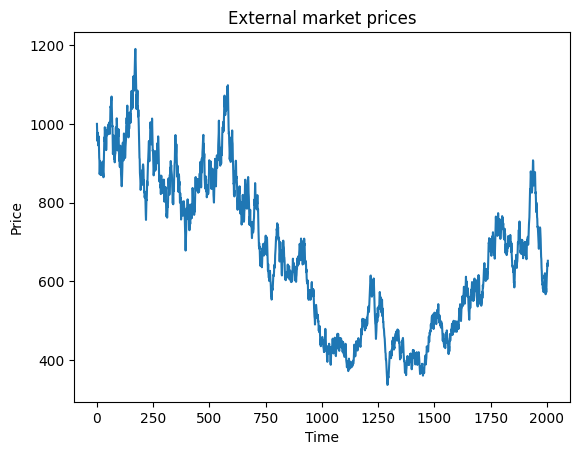

In [199]:
# with open('data/prices_cryptocompare.txt', 'r') as file:
#     external_prices = [float(line.strip()) for line in file]
#     # for the purpose of this test, each price will be treated as a second (price at line 1 is second 1, price at line 10 is second 10, etc...)

n_data_points = 2005
min_vol = 0.001
max_vol = 0.04
external_prices = generate_price_data(n_data_points, min_vol, max_vol)

plt.plot(external_prices)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('External market prices')
plt.show()

Arbitrageurs are more profitable on XRPL 100% of the time


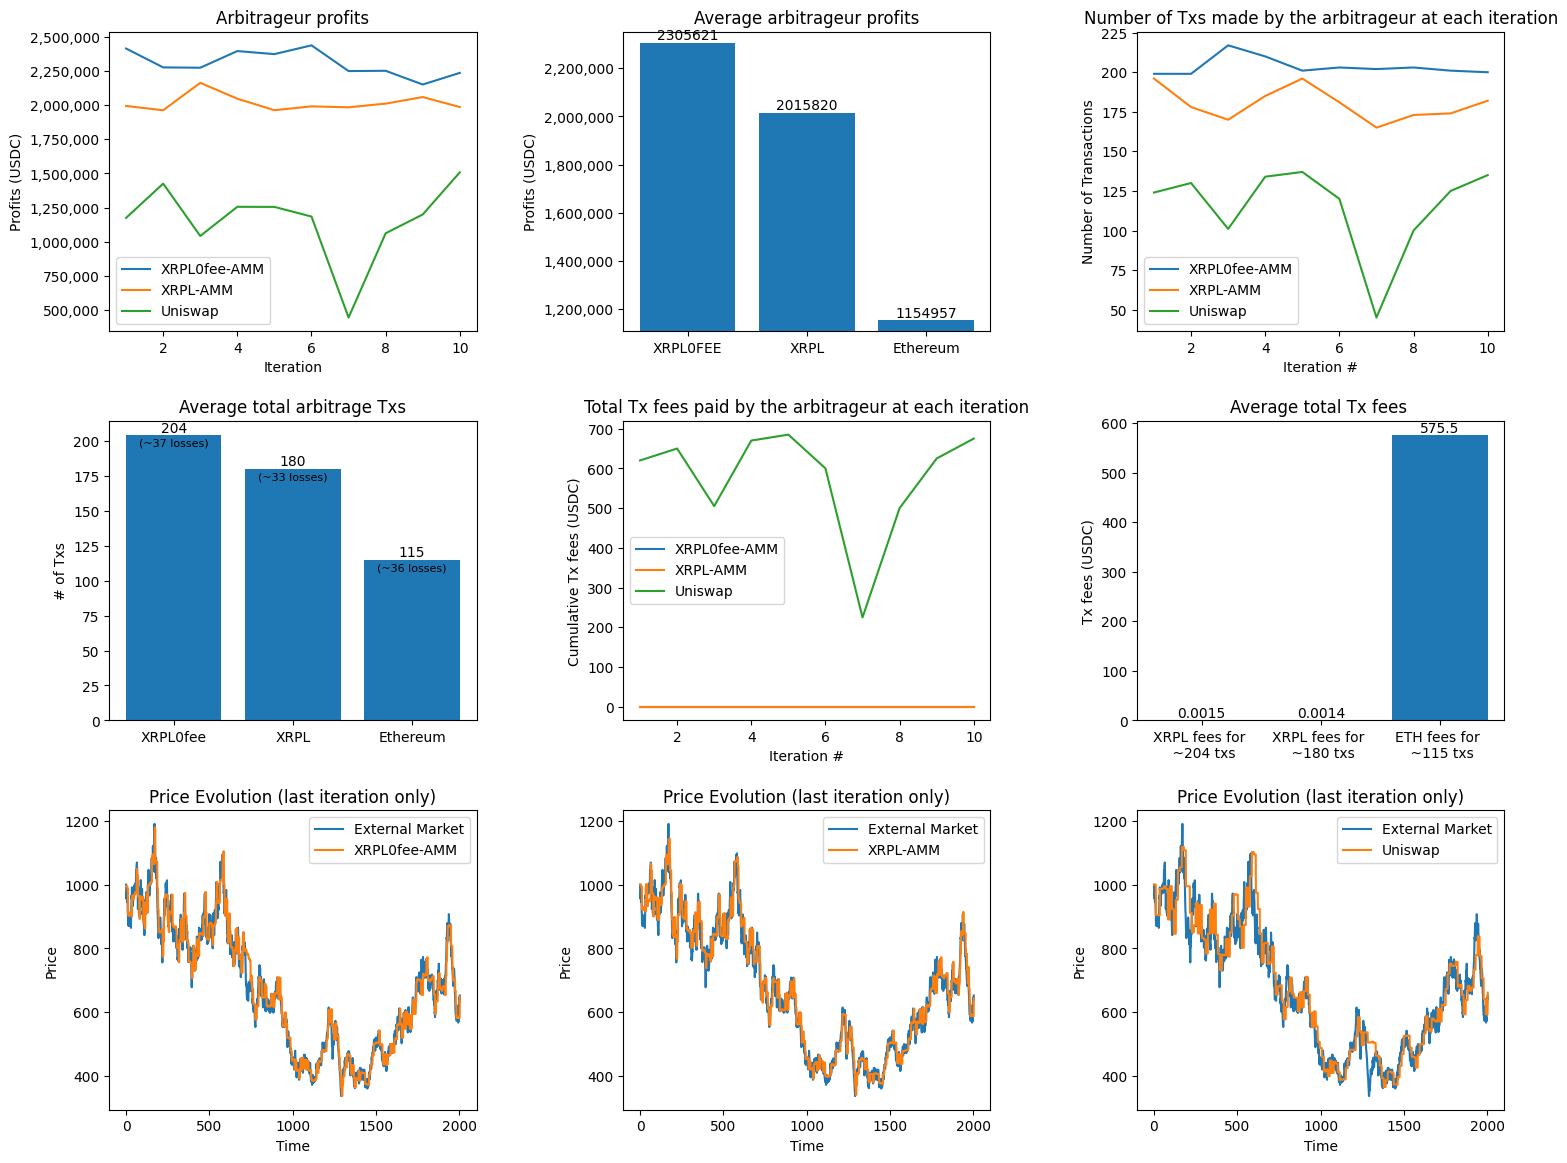

In [200]:
xrpl_block_conf = 4
eth_block_conf = 12
xrpl_fees = 0.0000075
eth_fees = 5
safe_profit_margin = 0.03
max_slippage = 0.05
iterations = 10

sim = simulator(external_prices, xrpl_block_conf, eth_block_conf, xrpl_fees, eth_fees, safe_profit_margin, max_slippage, iterations)
display_results(sim, external_prices, iterations, xrpl_fees, eth_fees)